# 网络威胁检测方法

In [174]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
import xgboost as xgb
import seaborn as sns
from torch.optim import lr_scheduler

## 导入数据集

导入 `data/20230406.csv` 以及 `data/20230509.csv` 两份数据集。

In [52]:
data1 = pd.read_csv('data/20230406.csv')
data2 = pd.read_csv('data/20230509.csv')
data = pd.concat([data1, data2])

data.columns

/var/folders/z5/9ww3z2cs05sdd9ppqbltwh5w0000gn/T/ipykernel_16444/249742214.py:1: DtypeWarning: Columns (7,9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('data/20230406.csv')


Index(['生成时间', '结束时间', '事件名称', '事件类型', '攻击结果', '威胁等级', '源IP', '源端口', '目的IP',
       '目的端口', '设备来源', '发生次数', '规则ID', '响应码', '设备动作', '请求体', '响应体', '研判'],
      dtype='object')

查看每一列的取值：

In [53]:
data.nunique()

生成时间     2863
结束时间     2871
事件名称      830
事件类型       27
攻击结果        3
威胁等级        4
源IP     15958
源端口     36515
目的IP      913
目的端口     2029
设备来源       45
发生次数      680
规则ID      834
响应码        34
设备动作        3
请求体     29680
响应体     12164
研判          3
dtype: int64

查看部分列具体有哪些种类：

In [54]:
event_type_v = data['事件类型'].unique()
attack_res_v = data['攻击结果'].unique()
threaten_lev_v = data['威胁等级'].unique()
response_code_v = data['响应码'].unique()
device_act_v = data['设备动作'].unique()
label_v = data['研判'].unique()

print("事件类型", event_type_v)
print("攻击结果", attack_res_v)
print("威胁等级", threaten_lev_v)
print("响应码", response_code_v)
print("设备动作", device_act_v)
print("研判", label_v)

事件类型 ['注入型攻击' '挖矿样本' '扫描探测' 'web漏洞攻击' '通用网络攻击' '目录遍历攻击' '远程登录' '蠕虫病毒' '拒绝服务攻击'
 '木马' '恶意后门' '账号弱口令' '主机漏洞攻击' '文件上传攻击' 'webshell攻击' '远程文件包含攻击' '勒索软件'
 '数据泄露' '远程代码命令执行' '缓冲区溢出攻击' '身份认证绕过' '反序列化攻击' '权限提升' '跨站脚本攻击' '未授权访问攻击'
 '账号暴力破解' '僵尸网络']
攻击结果 ['企图' '成功' '失败']
威胁等级 ['较大' '一般' '轻微' '重大']
响应码 ['0' '--' '200' '404' '403' '302' '400' '405' '100' '406' '511' '401'
 '501' '502' '301' '500' '206' '505' 0 200 404 403 100 401 302 400 501 406
 500 502 511 405 505 '417']
设备动作 ['允许' '--' '阻断']
研判 ['非攻击' '无法研判' '攻击']


# 数据预处理和清洗

这里发现响应码的类型不一致，考虑将其统一修改成字符串类型：

In [55]:
data['响应码'] = data['响应码'].astype(str)
response_code_v = data['响应码'].unique()
print("响应码", response_code_v)

响应码 ['0' '--' '200' '404' '403' '302' '400' '405' '100' '406' '511' '401'
 '501' '502' '301' '500' '206' '505' '417']


通过观察数据发现，“无法研判”的行中的请求体往往是一些乱码，而且该类标签对于做网络威胁检测的意义不大，
为了方便进行分类问题，首先删除所有研判结果为“无法研判”的行：

In [56]:
data = data[data['研判'] != '无法研判']
label_v = data['研判'].unique()
print("研判", label_v)

研判 ['非攻击' '攻击']


根据数据特征的类型:
+ 事件名称，事件类型，攻击结果，响应码，设备来源，规则ID，响应码，设备动作，研判 为离散格式，考虑先编码为整数格式(后采用独热编码)。
+ 威胁等级根据轻微，一般，较大，重大，为连续整数，考虑分别赋值为 0, 1, 2, 3；

In [57]:
def setup_map (column_name):
    tmp_map = dict()
    tmp = tuple(data[column_name].unique())
    for i in range(len(tmp)):
        tmp_map[tmp[i]] = i
    data[column_name] = data[column_name].map(tmp_map)

setup_map('事件名称')
setup_map('事件类型')
setup_map('攻击结果')
setup_map('设备来源')
setup_map('规则ID')
setup_map('响应码')
setup_map('设备动作')
setup_map('研判')

label_v = data['研判'].unique()
print("研判", label_v)

device_act_v = data['设备动作'].unique()
print("设备动作", device_act_v)


研判 [0 1]
设备动作 [0 1 2]


In [58]:
threat_level_mapping = {'轻微': 0, '一般': 1, '较大': 2, '重大': 3}
data['威胁等级'] = data['威胁等级'].map(threat_level_mapping)

print('威胁等级', data['威胁等级'].sample(5))

威胁等级 7662     1
46813    2
41105    2
4379     1
7949     2
Name: 威胁等级, dtype: int64


In [59]:
event_type_v = data['事件类型'].unique()
attack_res_v = data['攻击结果'].unique()
threaten_lev_v = data['威胁等级'].unique()
response_code_v = data['响应码'].unique()
device_act_v = data['设备动作'].unique()
label_v = data['研判'].unique()

print("事件类型", event_type_v)
print("攻击结果", attack_res_v)
print("威胁等级", threaten_lev_v)
print("响应码", response_code_v)
print("设备动作", device_act_v)
print("研判", label_v)

事件类型 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
攻击结果 [0 1 2]
威胁等级 [2 1 0 3]
响应码 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
设备动作 [0 1 2]
研判 [0 1]


In [226]:
data.shape

(57939, 18)

去掉生成时间和结束时间这两个对研判结果相关性不大的列，再考虑删除重复的行（数据集中的很多攻击都不止进行了一次）。

In [60]:
data = data.drop(['生成时间', '结束时间'], axis = 1)
data.drop_duplicates(inplace=True)
data.shape

(57892, 16)

In [61]:
data.isnull().sum()

事件名称     0
事件类型     0
攻击结果     0
威胁等级     0
源IP      0
源端口      0
目的IP     0
目的端口     0
设备来源     0
发生次数     0
规则ID     0
响应码      0
设备动作     0
请求体      0
响应体     55
研判       0
dtype: int64

将响应体列中的空值替换为一个空字符串：

In [62]:
data['响应体'] = data['响应体'].fillna('')
print(data['响应体'].isnull().sum())

0


查看部分研判结果为攻击的行：

In [63]:
selected_columns = ['源IP', '源端口', '目的IP', '目的端口', '请求体', '响应体']
print(data.loc[data['研判'] == 1, selected_columns].sample(5))

                                                     源IP      源端口   
31530                          115.194.118.178\n中国,浙江,杭州  34030\t  \
22665                                 36.138.140.208\n中国  46182\t   
31742  112.17.44.75(112.17.44.75)ip:112.17.44.75\n中国,...  37268\t   
31627                          122.224.146.227\n中国,浙江,杭州  35788\t   
24230                                 36.138.140.208\n中国  51732\t   

                                                    目的IP   目的端口   
31530  112.15.232.48(112.15.232.48)ip:112.15.232.48\n...  30230  \
22665  218.205.57.148(218.205.57.148)ip:218.205.57.14...   9001   
31742  39.173.77.32(39.173.77.32)ip:39.173.77.32\n中国,...   1162   
31627  218.205.111.73(218.205.111.73)ip:218.205.111.7...   9000   
24230  112.13.167.228(112.13.167.228)ip:112.13.167.22...   8060   

                                                     请求体   
31530  POST /cgi-bin/cgitest?LD_PRELOAD=/proc/self/fd...  \
22665  PUT ISOP#@!START/_users/org.couchdb.user:dvtlh...   
31

查看部分研判结果为非攻击的行：

In [81]:
print(data.loc[data['研判'] != 1, selected_columns].sample(5))

                                                     源IP      源端口   
38511                           39.185.215.115\n中国,浙江,宁波     9018  \
11718                      193.118.53.142\n荷兰,北荷兰省,阿姆斯特丹  42617\t   
33906                           117.147.40.254\n中国,浙江,杭州     6005   
1193   112.17.44.76(112.17.44.76)ip:112.17.44.76\n中国,...  33098\t   
7197                                 117.180.185.118\n中国  52397\t   

                                                    目的IP   目的端口   
38511  112.13.167.152(112.13.167.152)ip:112.13.167.15...  19081  \
11718  112.17.44.215(112.17.44.215)ip:112.17.44.215\n...   6969   
33906  112.13.167.152(112.13.167.152)ip:112.13.167.15...  19081   
1193    111.1.7.246(111.1.7.246)ip:111.1.7.246\n中国,浙江,台州   1161   
7197   211.140.12.65(211.140.12.65)ip:211.140.12.65\n...     53   

                                                     请求体   
38511  POSTISOP#@!START ISOP#@!END/rest/cmcc_softprob...  \
11718                                                 --   
33

我们发现攻击数据和非攻击数据在请求体和响应体上的差异很大，考虑解析这两个部分：
+ 解析 HTTP 请求：

In [151]:
def parse(rst):
    rst_lines = rst.splitlines()
    rstline = rst_lines[0]
    headers, body = ('\n'.join(rst_lines[1:])).split('\n\n', 1) if '\n\n' in rst else ('\n'.join(rst_lines[1:]), '')

    print("rst line = ", rstline)
    print("headers = ", headers)
    print("body = ", body)
    
# 取其中3行为试例：
rst1 = (data[data['研判'] == 1].sample(1))['请求体'].values[0]
parse(rst1)
print()

rst2 = (data[data['研判'] == 1].sample(1))['请求体'].values[0]
parse(rst2)
print()

rst3 = (data[data['研判'] == 1].sample(1))['请求体'].values[0]
parse(rst3)

rst line =  GET /${Class.forName("com.opensymphony.webwork.ServletActionContext").getMethod("getResponse",null).invoke(null,null).setHeader("X-Cmd-Response",Class.forName("javax.script.ScriptEngineManager").newInstance().getEngineByName("nashorn").eval("var d='';var i = java.lang.Runtime.getRuntime().exec('id').getInputStream(); while(i.available())d+=String.fromCharCode(i.read());d"))}/ HTTP/1.1 
headers =  Host: 112.13.167.100:8090 
User-Agent: Mozilla/5.0 zgrab/0.x 
Accept: */* 
Accept-Encoding: gzip 
 
body =  

rst line =  GET /member/ajax_membergroup.php?action=post&membergroup=@`'`/*!50000Union */ /*!50000select */ md5(910332797) -- @`'` HTTP/1.1 
headers =  Host: 218.205.111.5:8098 
User-Agent: Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36 
Accept: */* 
Accept-Encoding: gzip 
 
body =  

rst line =  POST /cgi-bin/twiki/bin/view HTTP/1.0
headers =  User-Agent: Mozilla/4.0 (compatible; MSIE 4.01; Windows 98)
Host: 22

可以发现请求体主要包含：请求行(rstline)，请求头(headers)，请求体(body)。

以上述三个为例：
+ 请求行可能出现注入攻击：此时请求行的长度比往常的长，可以考虑统计长度和字符出现的频率/方差进行判断。
+ 请求体中也可能注入恶意数据，还可能伪装用户代理信息等，可以考虑统计字符出现的频率/方差进行判断。此外还应该重点关注 Host 和 User-Agent 两行。
  在本次作业中，决定取 User-Agent 行的长度，字符频率方差，Host 长度，字符频率方差，Headers 字符频率方差共5个特征。
+ 请求体可能出现远程命令执行攻击：此时请求体相比于别的较为特殊，可以考虑统计字符出现的频率/方差进行判断。

In [64]:
def get_var(x):
    cnt = {}
    for c in x:
        if(c != ' '):
            cnt[c] = cnt.get(c, 0) + 1
    if(len(cnt) == 0):
        return 0
    mean_count = sum(cnt.values()) / len(cnt)
    sd = [(count - mean_count)**2 for count in cnt.values()]
    var = sum(sd) / len(cnt)
    return var

def get_len1(x): # rst line length
    if(x == '') :
        return 0
    else:
        return len(x.splitlines()[0])
    
def get_var1(x): # rst line char variance
    if(x == ''):
        return 0
    else:
        return get_var(x.splitlines()[0])
    

http_headers = [
    'Cache-Control', 'Connection', 'Date', 'Pragma', 'Trailer', 'Transfer-Encoding', 'Upgrade', 'Via', 'Warning',
    'Accept', 'Accept-Charset', 'Accept-Encoding', 'Accept-Language', 'Authorization', 'Expect', 'From', 'Host',
    'If-Match', 'If-Modified-Since', 'If-None-Match', 'If-Range', 'If-Unmodified-Since', 'Max-Forwards',
    'Proxy-Authorization', 'Range', 'Referer', 'TE', 'User-Agent',
    'Accept-Ranges', 'Age', 'ETag', 'Location', 'Proxy-Authenticate', 'Retry-After', 'Server', 'Vary', 'WWW-Authenticate',
    'Allow', 'Content-Encoding', 'Content-Language', 'Content-Length', 'Content-Location', 'Content-MD5', 'Content-Range',
    'Content-Type', 'Expires', 'Last-Modified'
]

def get_body(x):
    lines = x.splitlines()[1:]
    filtered_lines = [line for line in lines if not any(header in line for header in http_headers)]
    return ''.join(filtered_lines)

def get_header(x):
    lines = x.splitlines()[1:]
    filtered_lines = [line for line in lines if any(header in line for header in http_headers)]
    return '\n'.join(filtered_lines)

def get_user_agent(x):
    lines = x.splitlines()[1:]
    filtered_lines = [line for line in lines if ('User-Agent' in line)]
    return '\n'.join(filtered_lines)

def get_host(x):
    lines = x.splitlines()[1:]
    filtered_lines = [line for line in lines if ('Host' in line)]
    return '\n'.join(filtered_lines)

def get_var2(x): # body char variance
    if(x == ''):
        return 0
    else:
        return get_var(get_body(x))

def get_var3(x): # header variance
    if(x == ''):
        return 0
    else:
        return get_var(get_header(x))
    
def get_var4(x): # header User-Agent variance
    if(x == ''):
        return 0
    else:
        return get_var(get_user_agent(x))
    
def get_var5(x): # header Host variance
    if(x == ''):
        return 0
    else:
        return get_var(get_host(x))
    
def get_len2(x): # header User-Agent len
    if(x == ''):
        return 0
    else:
        return len(get_user_agent(x))
    
def get_len3(x): # header Host len
    if(x == ''):
        return 0
    else:
        return len(get_host(x))
    
# test get_header
print('header = ', get_header((data[data['研判'] == 1].head(1))['请求体'].values[0]))

# test get_body
print('body = ', get_body((data[data['研判'] == 1].head(1))['请求体'].values[0]))

# test user-agent
print('User-Agent = ', get_user_agent((data[data['研判'] == 1].head(1))['请求体'].values[0]))

# test host
print('Host = ', get_host((data[data['研判'] == 1].head(1))['请求体'].values[0]))


header =  Host: 112.13.167.114:8088
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36
Content-Length: 105
Accept: text/html,application/xhtml xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9
Accept-Language: zh-CN,zh;q=0.9
Connection: close
Content-Type: application/x-www-form-urlencoded; charset=UTF-8
Accept-Encoding: gzip
body =  X-Requested-With: XMLHttpRequest<?xml version="1.0" encoding="UTF-8"?><language>$(echo tbxyn${bwdlq}ccabu^uunzq>webLib/uunzq)</language>
User-Agent =  User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36
Host =  Host: 112.13.167.114:8088


将数据集中 '请求体' 替换成上述 8 个特征，将 '响应体' 替换成其字符频率方差。

In [65]:
rstlinelen = data['请求体'].apply(lambda x : get_len1(x))
useragentlen = data['请求体'].apply(lambda x : get_len2(x))
hostlen = data['请求体'].apply(lambda x : get_len3(x))
rstlinevar = data['请求体'].apply(lambda x : get_var1(x))
bodyvar = data['请求体'].apply(lambda x : get_var2(x))
headervar = data['请求体'].apply(lambda x : get_var3(x))
useragnetvar = data['请求体'].apply(lambda x : get_var4(x))
hostvar = data['请求体'].apply(lambda x : get_var5(x))
resvar = data['响应体'].apply(lambda x : get_var(x))

In [66]:
data['rstline_len'] = rstlinelen
data['useragent_len'] = useragentlen
data['hostlen'] = hostlen
data['rstlinevar'] = rstlinevar
data['bodyvar'] = bodyvar
data['headervar'] = headervar
data['useragentvar'] = useragentlen
data['hostvar'] = hostvar
data['resvar'] = resvar

data = data.drop(['请求体', '响应体'], axis=1)

print(data.columns)
print(data.shape)

Index(['事件名称', '事件类型', '攻击结果', '威胁等级', '源IP', '源端口', '目的IP', '目的端口', '设备来源',
       '发生次数', '规则ID', '响应码', '设备动作', '研判', 'rstline_len', 'useragent_len',
       'hostlen', 'rstlinevar', 'bodyvar', 'headervar', 'useragentvar',
       'hostvar', 'resvar'],
      dtype='object')
(57892, 23)


In [67]:
data.dtypes

事件名称               int64
事件类型               int64
攻击结果               int64
威胁等级               int64
源IP               object
源端口               object
目的IP              object
目的端口              object
设备来源               int64
发生次数               int64
规则ID               int64
响应码                int64
设备动作               int64
研判                 int64
rstline_len        int64
useragent_len      int64
hostlen            int64
rstlinevar       float64
bodyvar          float64
headervar        float64
useragentvar       int64
hostvar          float64
resvar           float64
dtype: object

用源端口的数量和目的端口的数量替换这两个特征：

In [68]:
def GetNUM(x):
    ret = 1
    for c in x:
        if c == ',':
            ret += 1
    return ret

data['目的端口'] = data['目的端口'].apply(lambda x: GetNUM(str(x)))
data['源端口'] = data['源端口'].apply(lambda x : GetNUM(str(x)))

In [69]:
print(max(data['目的端口']), max(data['源端口']))

100 100


查看 IP 地址的组成：

In [71]:
data['源IP'].sample(10)

9199        223.92.10.46\n中国,浙江,温州
16718          147.185.239.218\n美国
28606           36.138.140.208\n中国
30341           36.138.140.208\n中国
6925      183.136.225.31\n中国,浙江,嘉兴
47369           36.138.140.208\n中国
45798              1.117.84.70\n中国
7102               10.3.33.132\n--
26163           36.138.140.208\n中国
13294    123.152.193.186\n中国,浙江,宁波
Name: 源IP, dtype: object

考虑将 IP 特征转化整数表示，再提取IP所在国家城市（用字符串表示）为一个新的特征。

In [72]:
def getPosition(x):
    return x.splitlines()[1]

def getIPasInt(x):
    x = x.splitlines()[0]
    num = [0, 0, 0, 0]
    id = 0
    for c in x:
        if(c <= '9' and c >= '0'):
            num[id] = num[id] * 10 + (int(c) - int('0'))
        else:
            id += 1
        if (id == 4):
            break
    return num[0]*(256**3) + num[1]*(256**2) + num[2]*256 + num[3]

print(getIPasInt('151.80.13.43\n法国,上法兰西大区,鲁贝'))
print(getPosition('151.80.13.43\n法国,上法兰西大区,鲁贝'))

2538605867
法国,上法兰西大区,鲁贝


In [73]:
data['srcIPcity'] = data['源IP'].apply(lambda x : getPosition(x))
data['desIPcity'] = data['目的IP'].apply(lambda x : getPosition(x))

data['srcIP'] = data['源IP'].apply(lambda x : getIPasInt(x))
data['desIP'] = data['目的IP'].apply(lambda x : getIPasInt(x))

data = data.drop(['源IP','目的IP'],axis=1)
data.columns

Index(['事件名称', '事件类型', '攻击结果', '威胁等级', '源端口', '目的端口', '设备来源', '发生次数', '规则ID',
       '响应码', '设备动作', '研判', 'rstline_len', 'useragent_len', 'hostlen',
       'rstlinevar', 'bodyvar', 'headervar', 'useragentvar', 'hostvar',
       'resvar', 'srcIPcity', 'desIPcity', 'srcIP', 'desIP'],
      dtype='object')

注意：源头端 和 目的端口已经修改为其相应的个数。

In [77]:
data.sample(5)

,事件名称,事件类型,攻击结果,威胁等级,源端口,目的端口,设备来源,发生次数,规则ID,响应码,...,rstlinevar,bodyvar,headervar,useragentvar,hostvar,resvar,srcIPcity,desIPcity,srcIP,desIP
2909,1,1,1,2,1,1,1,1,1,0,...,0.000000,0.000000,0.00000,0,0.000000,0.0,美国,"中国,浙江,杭州",3355015169,1880174167
28482,126,5,0,1,1,1,13,9,132,6,...,22.552457,0.000000,5.26392,79,1.204082,0.0,中国,"中国,浙江,杭州",613059792,1879942991
8779,1,1,1,2,1,1,6,1,1,0,...,0.000000,0.000000,0.00000,0,0.000000,0.0,"美国,弗吉尼亚州,雷斯顿","中国,浙江,杭州",3223532318,1880174168
4928,781,4,0,1,1,1,1,2,786,0,...,0.146684,0.711538,0.00000,0,0.000000,0.0,"中国,广东,佛山","中国,浙江,宁波",2028677243,1972668715
801,6,4,1,2,1,1,6,5,6,0,...,0.000000,0.000000,0.00000,0,0.000000,0.0,美国,"中国,浙江,杭州",2728336367,1880174170


In [78]:
data.dtypes

事件名称               int64
事件类型               int64
攻击结果               int64
威胁等级               int64
源端口                int64
目的端口               int64
设备来源               int64
发生次数               int64
规则ID               int64
响应码                int64
设备动作               int64
研判                 int64
rstline_len        int64
useragent_len      int64
hostlen            int64
rstlinevar       float64
bodyvar          float64
headervar        float64
useragentvar       int64
hostvar          float64
resvar           float64
srcIPcity         object
desIPcity         object
srcIP              int64
desIP              int64
dtype: object

至此，最基础的数据特征预处理与清洗工作已经完成。

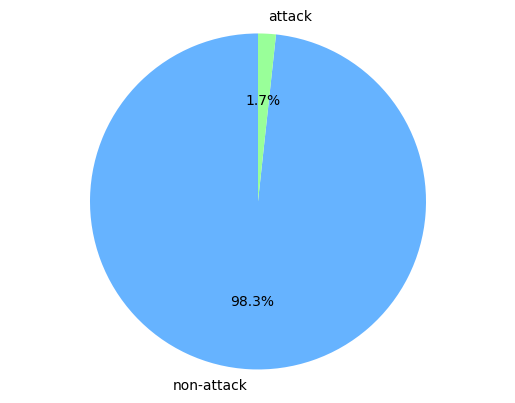

In [79]:
percentage = data['研判'].value_counts(normalize=True) * 100
plt.pie(percentage, labels=['non-attack','attack'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99'])
plt.axis('equal')
plt.show()

# 模型测试和效果评估

## 分割数据集

+ 在分割数据集之前，对之前提到的几个特征进行独热编码。

In [84]:
need_one_hot_columns = ['srcIPcity', 'desIPcity', '事件名称','事件类型','攻击结果','响应码','设备来源','规则ID','响应码','设备动作']
data_encoded = pd.get_dummies(data, columns=need_one_hot_columns)

+ 分割成训练集和测试集。

In [85]:
x = data_encoded.drop('研判', axis=1)
y = data_encoded['研判']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 模型评估函数

In [88]:
kernal_evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))
    
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))
    
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['non-attack', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

## 决策树算法

### 深度为最大为 6

Training Accuracy DecisionTreeClassifier 99.99784077904692  Test Accuracy DecisionTreeClassifier 99.54227480784178
Training Precesion DecisionTreeClassifier 100.0  Test Precesion DecisionTreeClassifier 84.61538461538461
Training Recall DecisionTreeClassifier 99.87389659520807  Test Recall DecisionTreeClassifier 89.34010152284264


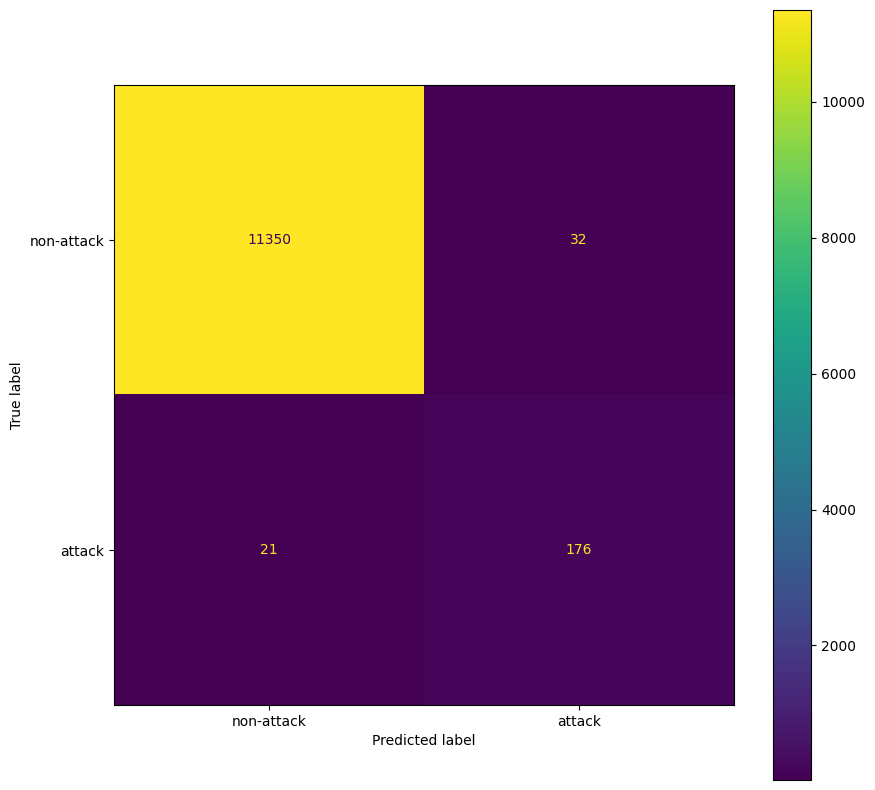

In [93]:
dt = DecisionTreeClassifier(max_depth=6).fit(x_train, y_train)
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", x_train, x_test, y_train, y_test)

分析特征的重要性程度：

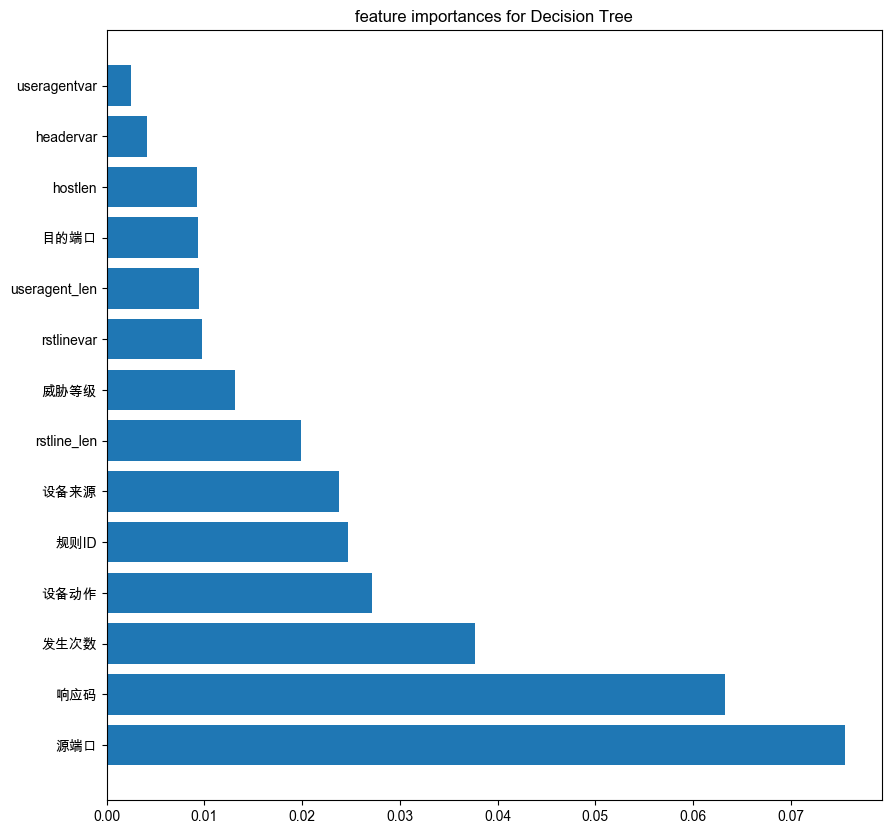

In [101]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    if top == -1:
        top = len(names)
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.figure(figsize=(10,10))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importances for Decision Tree')
    plt.show()

%matplotlib inline

features_names = data.drop(['研判'] , axis = 1)
f_importances(abs(tdt.feature_importances_), features_names, top=14)

[Text(0.7428571428571429, 0.9285714285714286, 'x[889] <= 0.5\ngini = 0.034\nsamples = 46313\nvalue = [45520, 793]'),
 Text(0.6, 0.7857142857142857, 'x[1810] <= 0.5\ngini = 0.032\nsamples = 46267\nvalue = [45516, 751]'),
 Text(0.4857142857142857, 0.6428571428571429, 'x[894] <= 0.5\ngini = 0.03\nsamples = 46226\nvalue = [45513, 713]'),
 Text(0.42857142857142855, 0.5, 'x[555] <= 0.5\ngini = 0.029\nsamples = 46197\nvalue = [45513, 684]'),
 Text(0.22857142857142856, 0.35714285714285715, 'x[757] <= 0.5\ngini = 0.028\nsamples = 46159\nvalue = [45507, 652]'),
 Text(0.11428571428571428, 0.21428571428571427, 'x[756] <= 0.5\ngini = 0.027\nsamples = 46130\nvalue = [45505, 625]'),
 Text(0.05714285714285714, 0.07142857142857142, 'gini = 0.026\nsamples = 46104\nvalue = [45504, 600]'),
 Text(0.17142857142857143, 0.07142857142857142, 'gini = 0.074\nsamples = 26\nvalue = [1, 25]'),
 Text(0.34285714285714286, 0.21428571428571427, 'x[16] <= 0.5\ngini = 0.128\nsamples = 29\nvalue = [2, 27]'),
 Text(0.28571

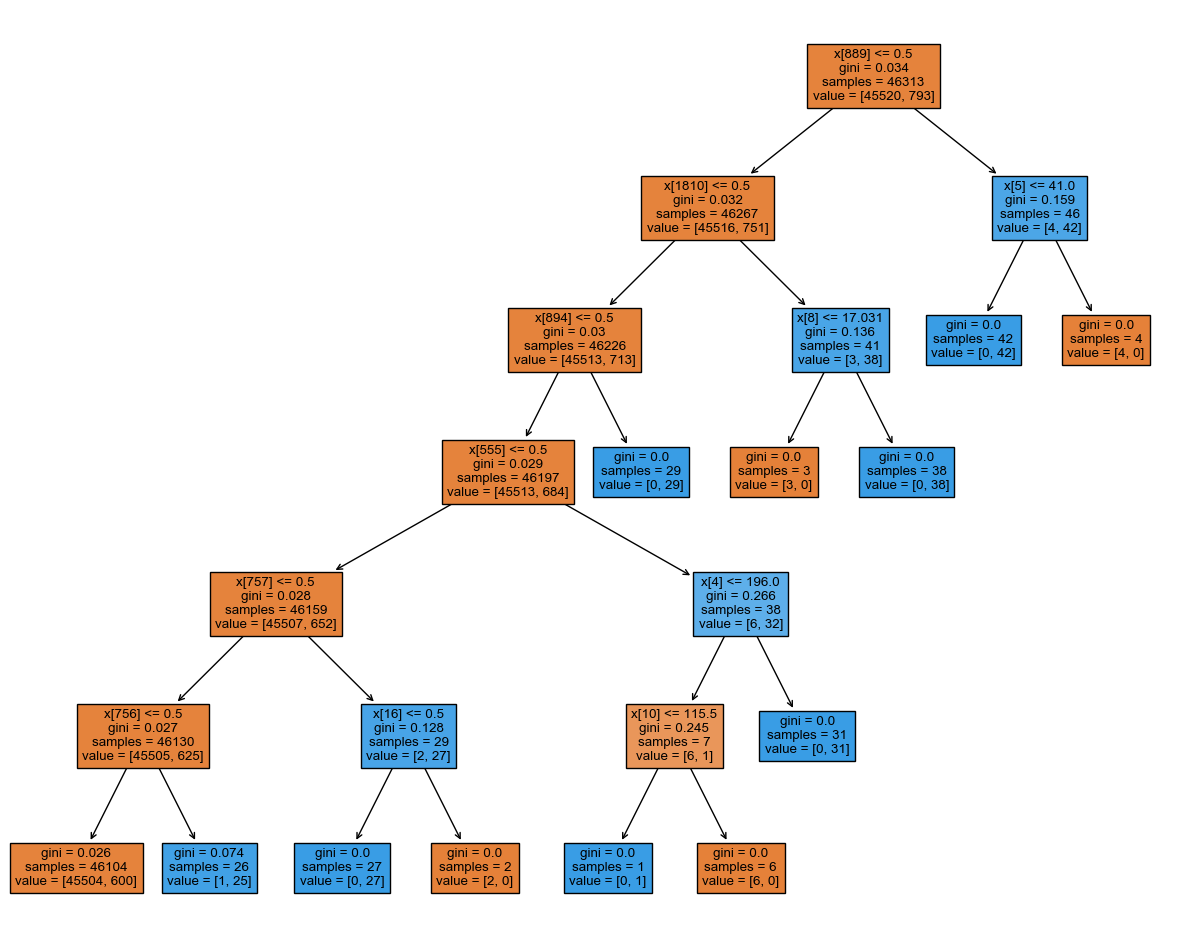

In [103]:
fig = plt.figure(figsize=(15,12))
tree.plot_tree(dt , filled=True)

### 深度最大为 10

Training Accuracy DecisionTreeClassifier 99.99784077904692  Test Accuracy DecisionTreeClassifier 99.55091113222213
Training Precesion DecisionTreeClassifier 100.0  Test Precesion DecisionTreeClassifier 85.02415458937197
Training Recall DecisionTreeClassifier 99.87389659520807  Test Recall DecisionTreeClassifier 89.34010152284264


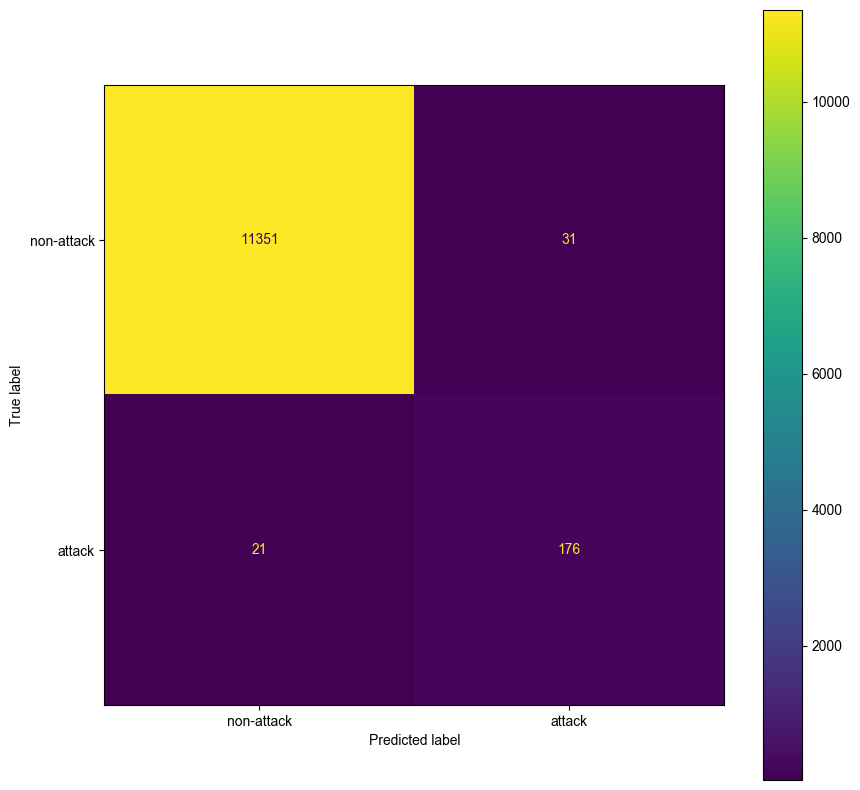

In [105]:
dt = DecisionTreeClassifier(max_depth=10).fit(x_train, y_train)
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", x_train, x_test, y_train, y_test)

[Text(0.8543983822042467, 0.9545454545454546, 'x[889] <= 0.5\ngini = 0.034\nsamples = 46313\nvalue = [45520, 793]'),
 Text(0.7735085945399394, 0.8636363636363636, 'x[890] <= 0.5\ngini = 0.032\nsamples = 46267\nvalue = [45516, 751]'),
 Text(0.7087967644084934, 0.7727272727272727, 'x[894] <= 0.5\ngini = 0.03\nsamples = 46226\nvalue = [45513, 713]'),
 Text(0.6764408493427705, 0.6818181818181818, 'x[555] <= 0.5\ngini = 0.029\nsamples = 46197\nvalue = [45513, 684]'),
 Text(0.5439838220424671, 0.5909090909090909, 'x[757] <= 0.5\ngini = 0.028\nsamples = 46159\nvalue = [45507, 652]'),
 Text(0.4408493427704752, 0.5, 'x[1676] <= 0.5\ngini = 0.027\nsamples = 46130\nvalue = [45505, 625]'),
 Text(0.3316481294236603, 0.4090909090909091, 'x[1356] <= 0.5\ngini = 0.026\nsamples = 46104\nvalue = [45504, 600]'),
 Text(0.2103134479271992, 0.3181818181818182, 'x[1475] <= 0.5\ngini = 0.024\nsamples = 46066\nvalue = [45496, 570]'),
 Text(0.12942366026289182, 0.22727272727272727, 'x[1380] <= 0.5\ngini = 0.023

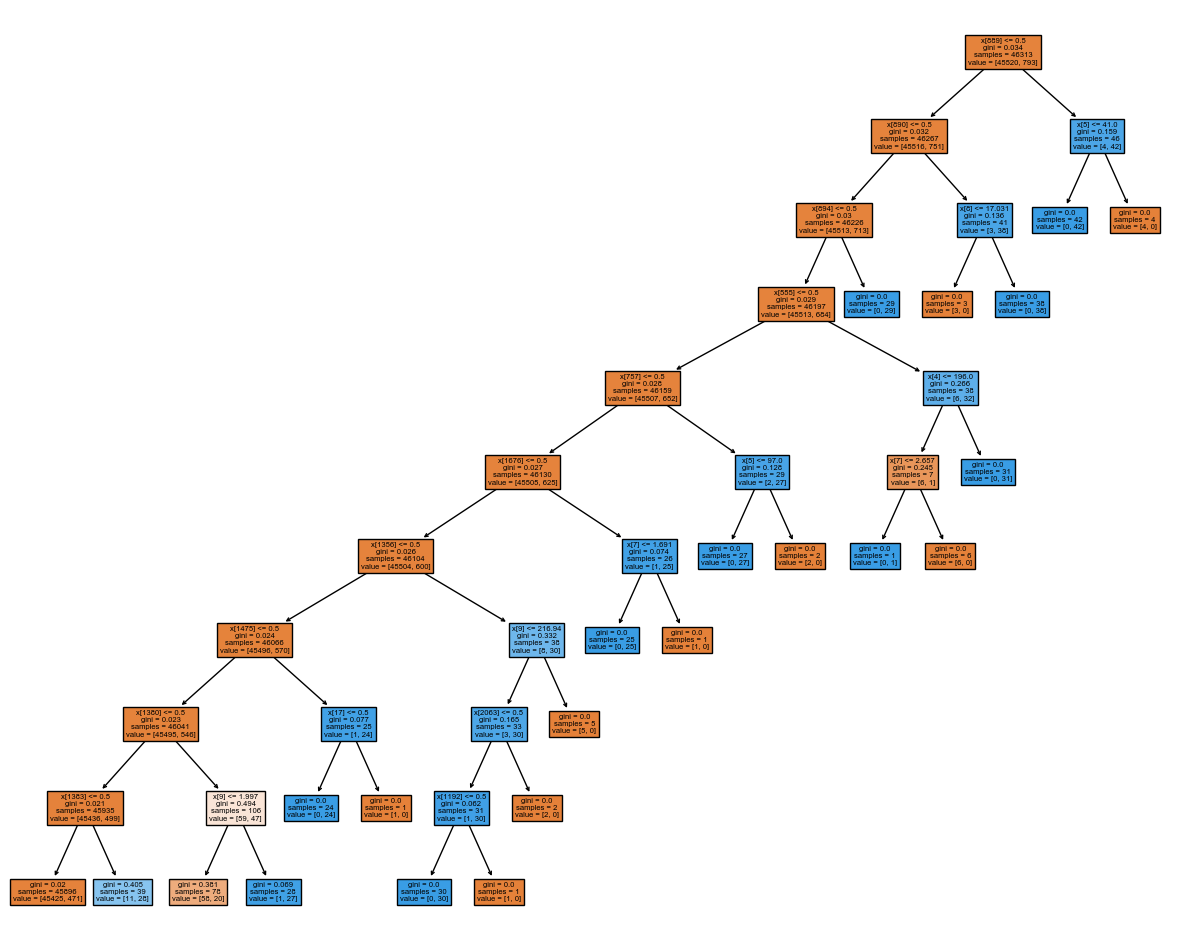

In [108]:
fig = plt.figure(figsize=(15,12))
tree.plot_tree(dt , filled=True)

### 深度最大为 3

Training Accuracy DecisionTreeClassifier 99.99784077904692  Test Accuracy DecisionTreeClassifier 99.57682010536317
Training Precesion DecisionTreeClassifier 100.0  Test Precesion DecisionTreeClassifier 86.63366336633663
Training Recall DecisionTreeClassifier 99.87389659520807  Test Recall DecisionTreeClassifier 88.83248730964468


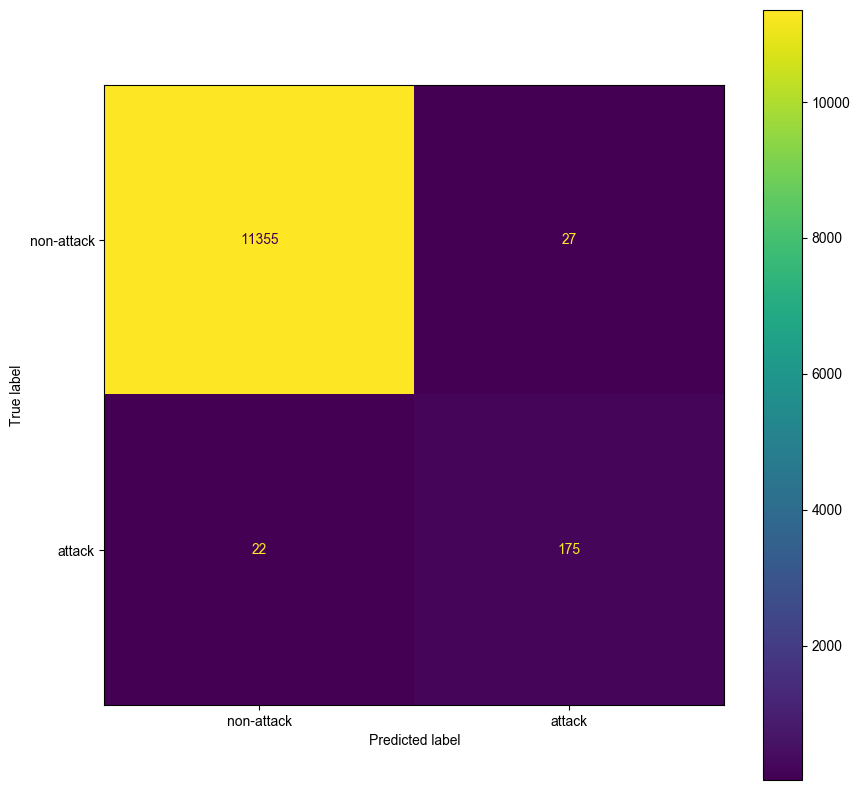

In [110]:
dt = DecisionTreeClassifier(max_depth=2).fit(x_train, y_train)
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", x_train, x_test, y_train, y_test)

[Text(0.5, 0.8333333333333334, 'x[889] <= 0.5\ngini = 0.034\nsamples = 46313\nvalue = [45520, 793]'),
 Text(0.25, 0.5, 'x[1810] <= 0.5\ngini = 0.032\nsamples = 46267\nvalue = [45516, 751]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.03\nsamples = 46226\nvalue = [45513, 713]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.136\nsamples = 41\nvalue = [3, 38]'),
 Text(0.75, 0.5, 'x[3] <= 10.5\ngini = 0.159\nsamples = 46\nvalue = [4, 42]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 42\nvalue = [0, 42]')]

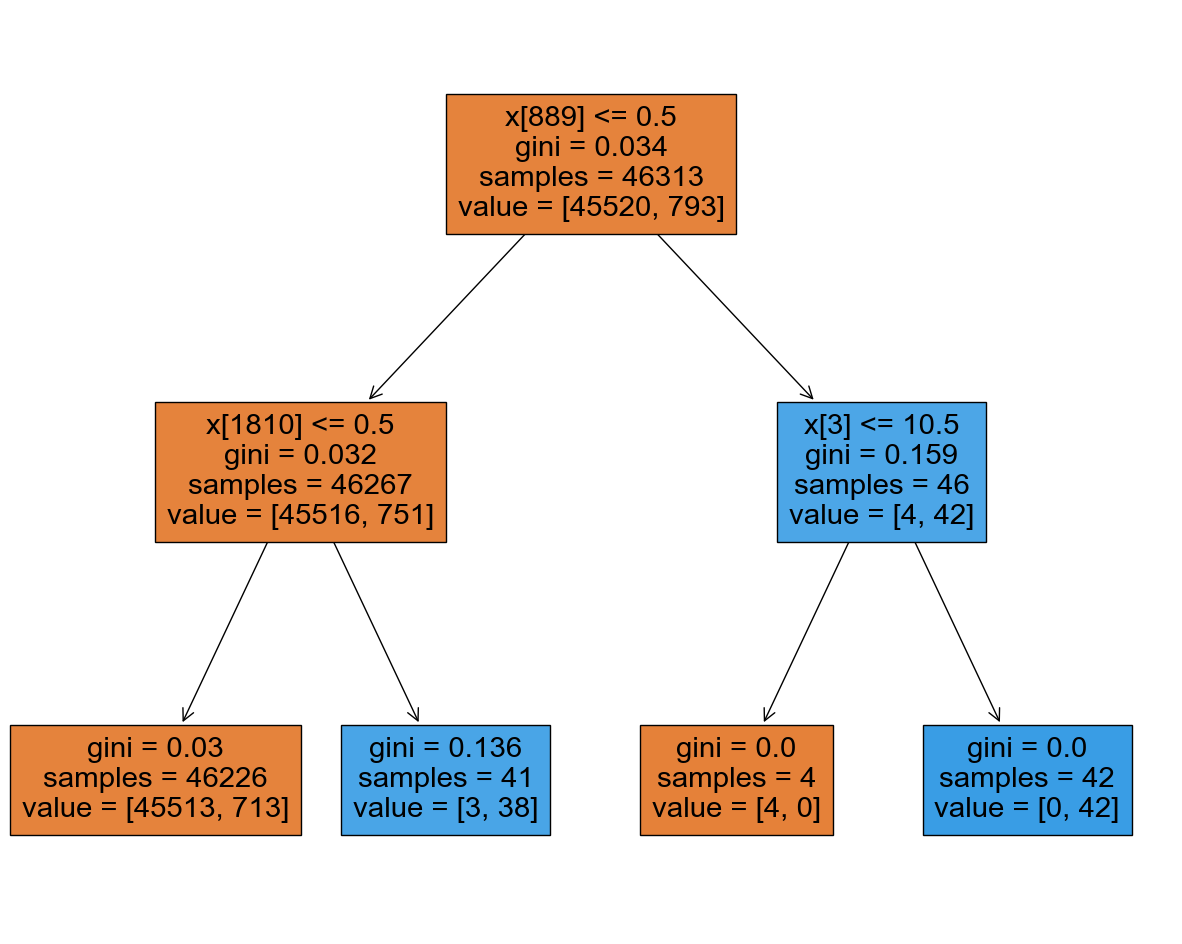

In [111]:
fig = plt.figure(figsize=(15,12))
tree.plot_tree(dt , filled=True)

## K临近算法（KNN）

Training Accuracy KNeighborsClassifier 98.32660376136289  Test Accuracy KNeighborsClassifier 98.35046204335434
Training Precesion KNeighborsClassifier 73.68421052631578  Test Precesion KNeighborsClassifier 71.42857142857143
Training Recall KNeighborsClassifier 3.5308953341740232  Test Recall KNeighborsClassifier 5.0761421319796955


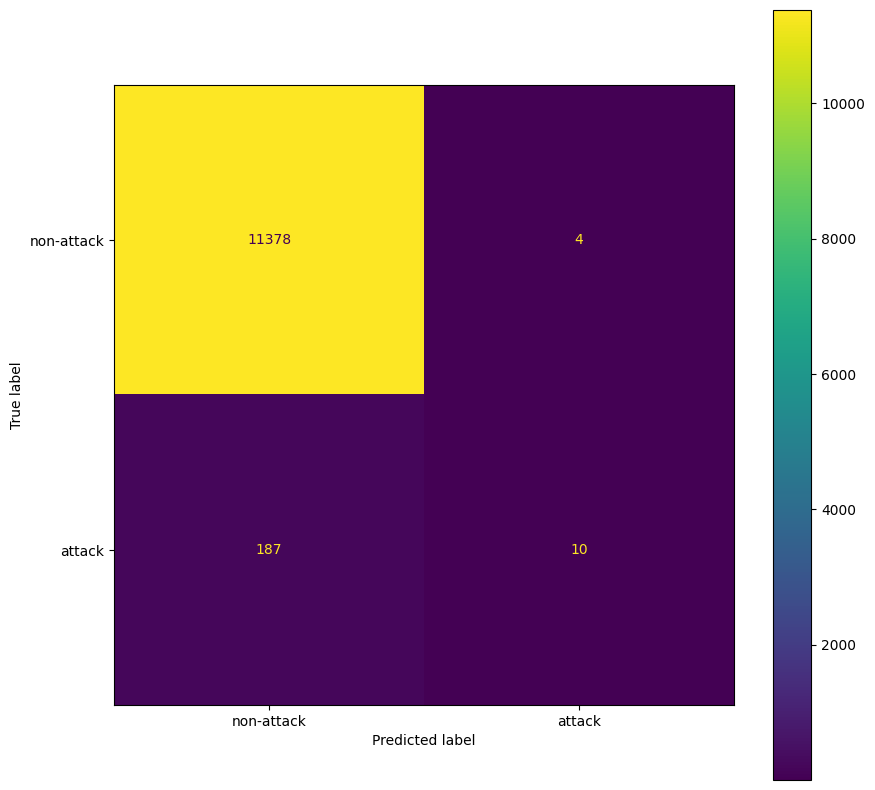

In [94]:
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)
evaluate_classification(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)

## 朴素贝叶斯法

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy GaussianNB 98.28773778420747  Test Accuracy GaussianNB 98.29864409707228
Training Precesion GaussianNB 0.0  Test Precesion GaussianNB 0.0
Training Recall GaussianNB 0.0  Test Recall GaussianNB 0.0


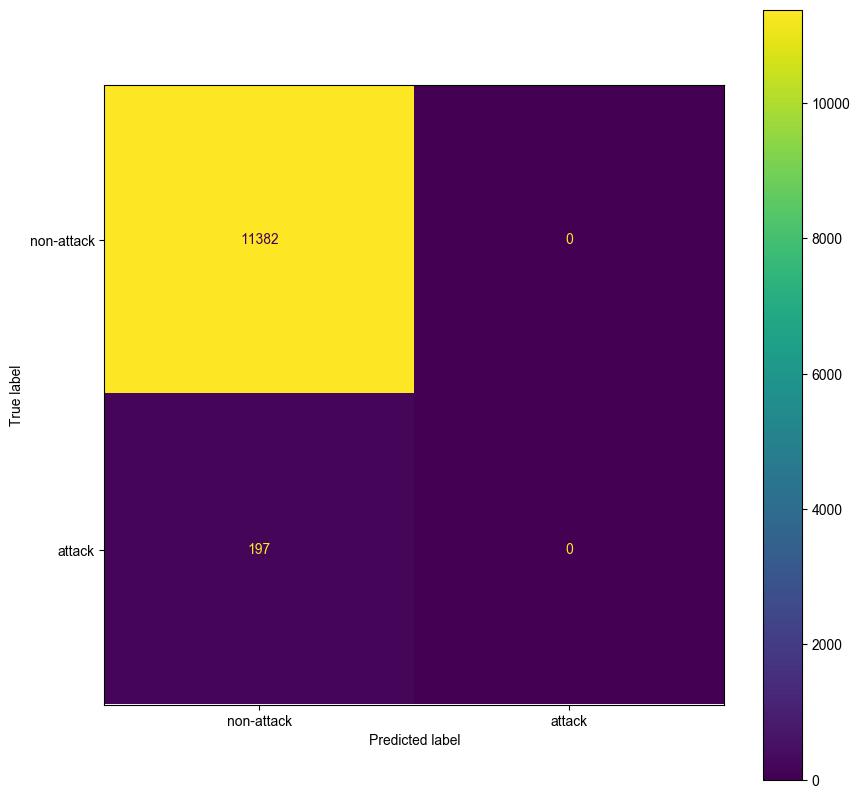

In [102]:
gnb = GaussianNB().fit(x_train, y_train)
evaluate_classification(gnb, "GaussianNB", x_train, x_test, y_train, y_test)

## 支持向量机（SVM）

/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy Linear SVC(LBasedImpl) 98.28773778420747  Test Accuracy Linear SVC(LBasedImpl) 98.29864409707228
Training Precesion Linear SVC(LBasedImpl) 0.0  Test Precesion Linear SVC(LBasedImpl) 0.0
Training Recall Linear SVC(LBasedImpl) 0.0  Test Recall Linear SVC(LBasedImpl) 0.0


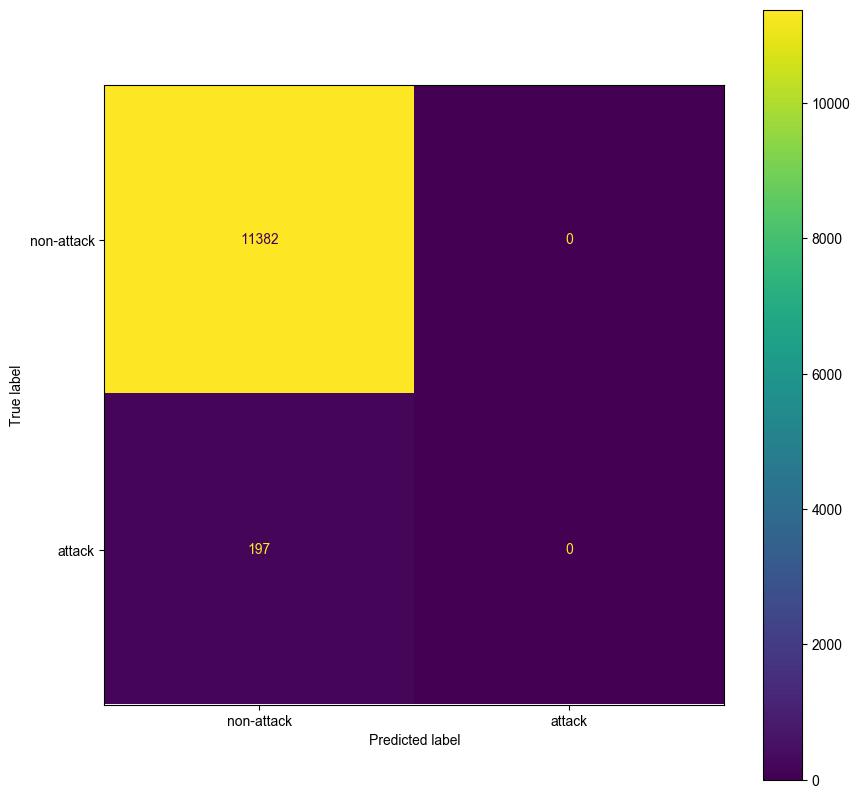

In [112]:
lin_svc = svm.LinearSVC().fit(x_train, y_train)
evaluate_classification(lin_svc, "Linear SVC(LBasedImpl)", x_train, x_test, y_train, y_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Accuracy SVC with RBF Kernel 98.28773778420747  Test Accuracy SVC with RBF Kernel 98.29864409707228
Training Precesion SVC with RBF Kernel 0.0  Test Precesion SVC with RBF Kernel 0.0
Training Recall SVC with RBF Kernel 0.0  Test Recall SVC with RBF Kernel 0.0


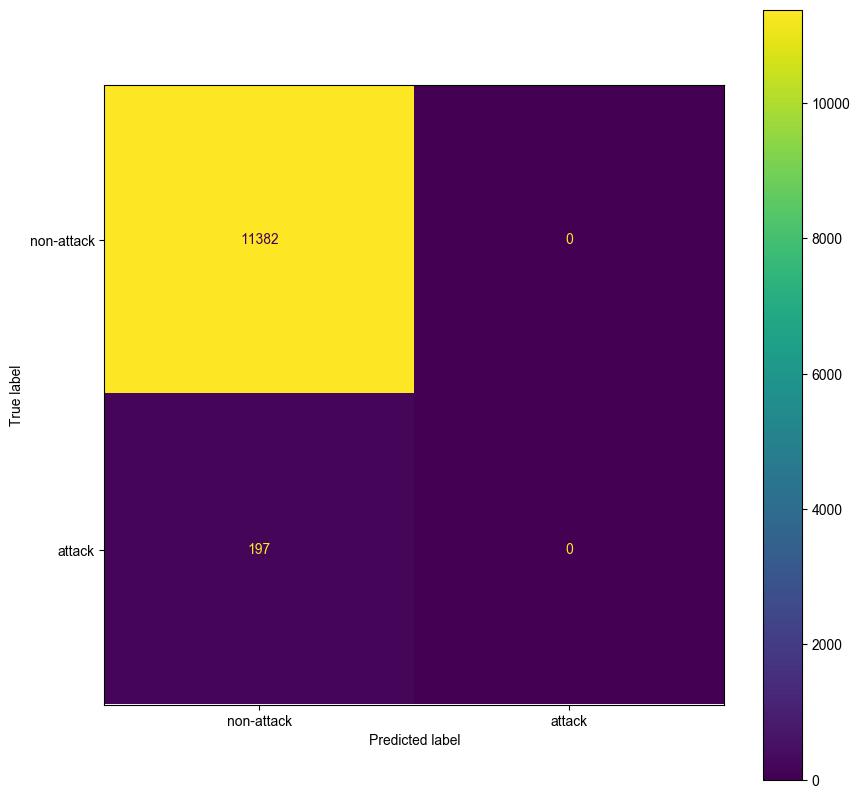

In [113]:
rbf_svc = svm.SVC(kernel='rbf').fit(x_train, y_train)
evaluate_classification(rbf_svc, "SVC with RBF Kernel", x_train, x_test, y_train, y_test)

## 随机森林

Training Accuracy RandomForestClassifier 99.99784077904692  Test Accuracy RandomForestClassifier 99.3868209689956
Training Precesion RandomForestClassifier 100.0  Test Precesion RandomForestClassifier 93.75
Training Recall RandomForestClassifier 99.87389659520807  Test Recall RandomForestClassifier 68.52791878172589


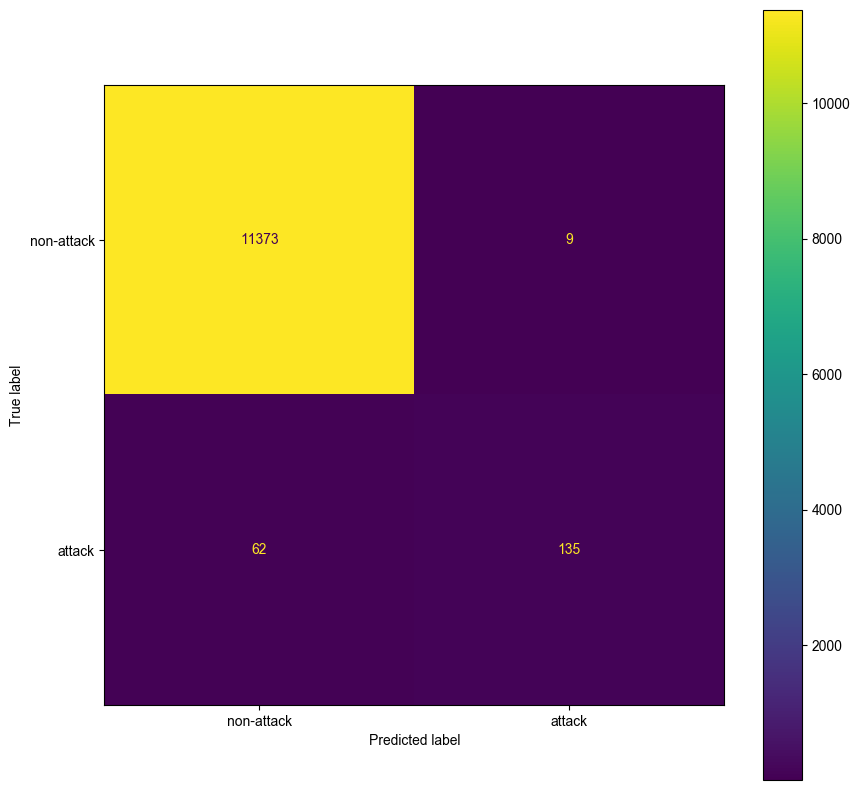

In [114]:
rf = RandomForestClassifier().fit(x_train, y_train)
evaluate_classification(rf, "RandomForestClassifier", x_train, x_test, y_train, y_test)

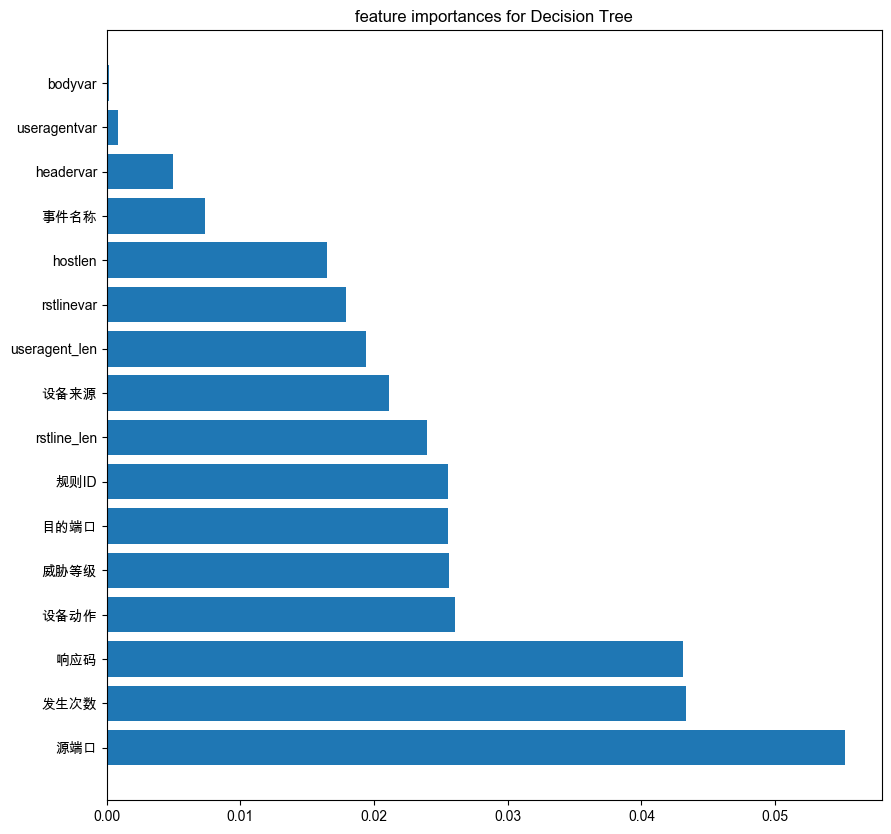

In [116]:
f_importances(abs(rf.feature_importances_), features_names, top=16)

### eXtreme Gradient Boosting

In [149]:
x_ = data.drop(['研判', 'srcIPcity', 'desIPcity'], axis=1)
y_ = data['研判']

x_train_, x_test_, y_train_, y_test_ = train_test_split(x_, y_, test_size=0.2, random_state=42)

In [150]:
xg_r = xgb.XGBRegressor(objective ='reg:linear',n_estimators = 10000).fit(x_train_, y_train_)

/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [03:04:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [159]:
name = "XGBOOST"
train_error = metrics.mean_squared_error(y_train_, xg_r.predict(x_train_), squared=False)
test_error = metrics.mean_squared_error(y_test_, xg_r.predict(x_test_), squared=False)
print("Training Error " + str(name) + " {}  Test error ".format(train_error) + str(name) + " {}".format(test_error))

Training Error XGBOOST 0.005215406377251053  Test error XGBOOST 0.054076832985980317


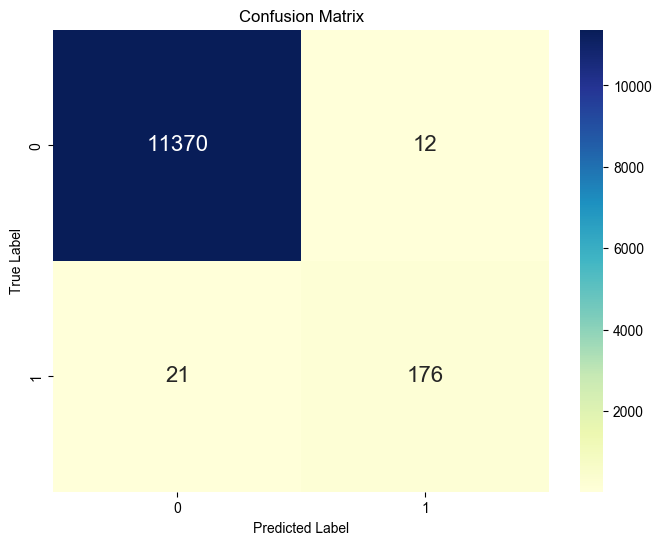

In [175]:
y_pred = xg_r.predict(x_test_)
y_pred_binary = (y_pred > 0.5).astype(int)
cm = metrics.confusion_matrix(y_test_, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [3]:
accuracy = (11370 + 176)/ (11370+176+12+21)
precision = (176) / (176+12)
recall = 176 / (21 + 176)

print(f'Accuracy: {accuracy:.10f}')
print(f'Precision: {precision:.10f}')
print(f'Recall: {recall:.10f}')

Accuracy: 0.9971500130
Precision: 0.9361702128
Recall: 0.8934010152


## 线性神经网络

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [136]:
x_train_ = torch.FloatTensor(x_train_.values)
y_train_ = torch.FloatTensor(y_train_.values)
x_test_ = torch.FloatTensor(x_test_.values)
y_test_ = torch.FloatTensor(y_test_.values)

In [146]:
class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(x_train_.shape[1], 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


model = ImprovedNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(x_train_)
    loss = criterion(outputs.squeeze(), y_train_)
    loss.backward()
    optimizer.step()
    scheduler.step()

    with torch.no_grad():
        model.eval()
        outputs_test = model(x_test_)
        predicted_test = (outputs_test.squeeze() > 0.5).float()
        accuracy_test = (predicted_test == y_test_).sum().item() / len(y_test_)

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {loss.item()}, Test Accuracy: {accuracy_test}')

with torch.no_grad():
    model.eval()
    outputs_final = model(x_test_)
    predicted_final = (outputs_final.squeeze() > 0.5).float()
    accuracy_final = (predicted_final == y_test_).sum().item() / len(y_test_)

print(f'Final Test Accuracy: {accuracy_final}')


Epoch 1/20, Training Loss: 0.8375369906425476, Test Accuracy: 0.9829864409707229
Epoch 2/20, Training Loss: 0.4039837419986725, Test Accuracy: 0.9829864409707229
Epoch 3/20, Training Loss: 0.1287190467119217, Test Accuracy: 0.9829864409707229
Epoch 4/20, Training Loss: 0.08990456163883209, Test Accuracy: 0.9829864409707229
Epoch 5/20, Training Loss: 0.09505240619182587, Test Accuracy: 0.9829864409707229
Epoch 6/20, Training Loss: 0.10558175295591354, Test Accuracy: 0.9829864409707229
Epoch 7/20, Training Loss: 0.10645735263824463, Test Accuracy: 0.9829864409707229
Epoch 8/20, Training Loss: 0.10709362477064133, Test Accuracy: 0.9829864409707229
Epoch 9/20, Training Loss: 0.10753706842660904, Test Accuracy: 0.9829864409707229
Epoch 10/20, Training Loss: 0.10781864076852798, Test Accuracy: 0.9829864409707229
Epoch 11/20, Training Loss: 0.10796122997999191, Test Accuracy: 0.9829864409707229
Epoch 12/20, Training Loss: 0.10796357691287994, Test Accuracy: 0.9829864409707229
Epoch 13/20, Tra